# First contact with the dataset
This Notebook has as objective to replicate the baseline results from Minixhofer et al. (2021)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter



**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [2]:
writer = SummaryWriter('../logs/LSTM_Minixhofer')

## Importing the data in a unique dictionary

In [3]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [4]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }


In [5]:
dataDic["train"].columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

In [6]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [7]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [8]:
dfs["train"]

PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
fips  date                                                                 
1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
      2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
      2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
      2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
      2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   
...                   ...     ...    ...    ...     ...     ...      ...   
56043 2016-12-27     0.16   82.88   1.63  -7.97  -13.49  -12.81    -1.39   
      2016-12-28     0.02   83.33   1.41  -8.71  -14.10  -13.84    -2.49   
      2016-12-29     0.00   83.75   1.59  -7.96  -13.30  -13.03     0.42   
      2016-12-30     1.22   82.49   2.63  -2.94   -7.40   -7.33     3.76   
      2016-12-31     0.44   82.19   1.75  -7.56  -11.98  -11.82    -0.95   

                  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
fips  date                                                                 
1001  2000-01-01    11.46       9.50  14.65   2.20       2.94       1.49   
      2000-01-02    12.61      10.18  16.60   2.52       3.43       1.83   
      2000-01-03    15.32       7.41  18.41   4.03       5.33       2.66   
      2000-01-04     2.16      15.92  11.31   3.84       5.67       2.08   
      2000-01-05    -2.66      13.48   2.65   1.60       2.50       0.52   
...                   ...        ...    ...    ...        ...        ...   
56043 2016-12-27   -13.60      12.21  -9.41   5.90       7.63       3.61   
      2016-12-28   -13.56      11.07 -10.55   6.50      11.43       4.11   
      2016-12-29   -14.51      14.93 -10.29   4.29       6.24       2.03   
      2016-12-30    -6.86      10.62  -4.14   4.98       7.34       1.99   
      2016-12-31   -11.61      10.66 -10.17   2.31       3.47       0.41   

                  WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
fips  date                                                                      
1001  2000-01-01         1.46   4.85       6.04       3.23         2.81    NaN  
      2000-01-02         1.60   5.33       6.13       3.72         2.41    NaN  
      2000-01-03         2.67   7.53       9.52       5.87         3.66    NaN  
      2000-01-04         3.59   6.73       9.31       3.74         5.58    1.0  
      2000-01-05         1.98   2.94       4.85       0.65         4.19    NaN  
...                       ...    ...        ...        ...          ...    ...  
56043 2016-12-27         4.02   8.58      10.39       5.92         4.47    0.0  
      2016-12-28         7.32   9.92      14.49       7.26         7.22    NaN  
      2016-12-29         4.22   6.56      10.07       3.20         6.87    NaN  
      2016-12-30         5.35   7.28      10.12       3.24         6.89    NaN  
      2016-12-31         3.06   3.37       5.26       0.66         4.60    NaN  

[19300680 rows x 19 columns]

## Interpolation pour les données manquantes

In [9]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [10]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [11]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [12]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [ ]:
X_tabular_train, X_time_train, y_target_train = loadXY("train")
print("train shape", X_time_train.shape)
X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
print("validation shape", X_time_valid.shape)
X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
print("test shape", X_time_test.shape)
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

# export all
np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
np.save("../data/processed_no_cat_and_no_tensors/valid_fips.npy", valid_fips)
np.save("../data/processed_no_cat_and_no_tensors/test_fips.npy", test_fips)

100%|██████████| 3108/3108 [08:53<00:00,  5.82it/s]


loaded 103390 samples
train shape (103390, 180, 21)


100%|██████████| 3108/3108 [00:49<00:00, 63.17it/s]


loaded 8748 samples
validation shape (8748, 180, 21)


100%|██████████| 30/30 [00:00<00:00, 8414.97it/s]


In [14]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 10
clip = 5

In [15]:
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [ ]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim=0,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1):
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim + static_dim, hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static=None):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        if static is not None:
            static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [17]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0
if use_static:
    static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)
model.to(device)
loss_function = nn.MSELoss()
if one_cycle:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        if use_static:
            output, h = model(inputs, h, static)
        else:
            output, h = model(inputs, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if one_cycle:
            scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    if use_static:
                        out, val_h = model(inp, val_h, stat)
                    else:
                        out, val_h = model(inp, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./state_dict.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/10:  50%|█████     | 404/808 [02:27<26:52,  3.99s/it]

{'loss': 0.4351786971092224, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 1, 'validation_loss': np.float64(0.4442593615124191), 'macro_f1': np.float64(0.4498263597196379), 'micro_f1': np.float64(0.647119341563786), 'mae': np.float64(0.47188933994866117)}
{'loss': 0.4351786971092224, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 2, 'validation_loss': np.float64(0.4442593615124191), 'macro_f1': np.float64(0.43908680044285747), 'micro_f1': np.float64(0.668609967992684), 'mae': np.float64(0.46281182693657963)}
{'loss': 0.4351786971092224, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 3, 'validation_loss': np.float64(0.4442593615124191), 'macro_f1': np.float64(0.3473750316712812), 'micro_f1': np.float64(0.5685871056241426), 'mae': np.float64(0.5458380318433986)}
{'loss': 0.4351786971092224, 'epoch': 0.5, 'step': 404, 'lr': 7.305177512317032e-06, 'week': 4, 'validation_loss': np.float64(0.4442593615124191), 'macro_f1': np.float64(0.35304

epoch 1/10: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.22661501169204712, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 1, 'validation_loss': np.float64(0.2469563425883003), 'macro_f1': np.float64(0.7704746611909696), 'micro_f1': np.float64(0.8681984453589392), 'mae': np.float64(0.22148829704342513)}
{'loss': 0.22661501169204712, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 2, 'validation_loss': np.float64(0.2469563425883003), 'macro_f1': np.float64(0.6696165564603539), 'micro_f1': np.float64(0.8161865569272977), 'mae': np.float64(0.2643039307593424)}
{'loss': 0.22661501169204712, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 3, 'validation_loss': np.float64(0.2469563425883003), 'macro_f1': np.float64(0.6395785613922662), 'micro_f1': np.float64(0.7776634659350709), 'mae': np.float64(0.316322841602378)}
{'loss': 0.22661501169204712, 'epoch': 1.0, 'step': 808, 'lr': 1.9612577643465342e-05, 'week': 4, 'validation_loss': np.float64(0.2469563425883003), 'macro_f1': np.float64(

epoch 2/10:  50%|█████     | 404/808 [02:29<26:46,  3.98s/it]

{'loss': 0.3078015148639679, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 1, 'validation_loss': np.float64(0.2376963198724864), 'macro_f1': np.float64(0.7656482538521825), 'micro_f1': np.float64(0.8784865112025606), 'mae': np.float64(0.19177547314443294)}
{'loss': 0.3078015148639679, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 2, 'validation_loss': np.float64(0.2376963198724864), 'macro_f1': np.float64(0.7033309178582686), 'micro_f1': np.float64(0.8271604938271605), 'mae': np.float64(0.243580186531394)}
{'loss': 0.3078015148639679, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 3, 'validation_loss': np.float64(0.2376963198724864), 'macro_f1': np.float64(0.6497776695283813), 'micro_f1': np.float64(0.7845221764974851), 'mae': np.float64(0.2949021319704181)}
{'loss': 0.3078015148639679, 'epoch': 1.5, 'step': 1212, 'lr': 3.6421782399043904e-05, 'week': 4, 'validation_loss': np.float64(0.2376963198724864), 'macro_f1': np.float64(

epoch 2/10: 100%|██████████| 808/808 [04:58<00:00,  2.70it/s]


{'loss': 0.2360876500606537, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 1, 'validation_loss': np.float64(0.2260988319589608), 'macro_f1': np.float64(0.6354325927894585), 'micro_f1': np.float64(0.8754000914494742), 'mae': np.float64(0.17247564261944545)}
{'loss': 0.2360876500606537, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 2, 'validation_loss': np.float64(0.2260988319589608), 'macro_f1': np.float64(0.5641428862782946), 'micro_f1': np.float64(0.8235025148605396), 'mae': np.float64(0.2312678481528196)}
{'loss': 0.2360876500606537, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 3, 'validation_loss': np.float64(0.2260988319589608), 'macro_f1': np.float64(0.46187514556517634), 'micro_f1': np.float64(0.7782350251486054), 'mae': np.float64(0.28677818393055365)}
{'loss': 0.2360876500606537, 'epoch': 2.0, 'step': 1616, 'lr': 5.322514587043574e-05, 'week': 4, 'validation_loss': np.float64(0.2260988319589608), 'macro_f1': np.float64(0

epoch 3/10:  50%|█████     | 404/808 [02:29<26:41,  3.96s/it]

{'loss': 0.24690169095993042, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 1, 'validation_loss': np.float64(0.2280341402452061), 'macro_f1': np.float64(0.6990943715725239), 'micro_f1': np.float64(0.8835162322816644), 'mae': np.float64(0.17510924390352536)}
{'loss': 0.24690169095993042, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 2, 'validation_loss': np.float64(0.2280341402452061), 'macro_f1': np.float64(0.6321483595875185), 'micro_f1': np.float64(0.8271604938271605), 'mae': np.float64(0.23523394315967383)}
{'loss': 0.24690169095993042, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 3, 'validation_loss': np.float64(0.2280341402452061), 'macro_f1': np.float64(0.5853033082018435), 'micro_f1': np.float64(0.782350251486054), 'mae': np.float64(0.2938879702673287)}
{'loss': 0.24690169095993042, 'epoch': 2.5, 'step': 2020, 'lr': 6.551658857891442e-05, 'week': 4, 'validation_loss': np.float64(0.2280341402452061), 'macro_f1': np.float64

epoch 3/10: 100%|██████████| 808/808 [04:58<00:00,  2.71it/s]


{'loss': 0.2587582468986511, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 1, 'validation_loss': np.float64(0.22503568480412164), 'macro_f1': np.float64(0.7833027137355949), 'micro_f1': np.float64(0.8827160493827161), 'mae': np.float64(0.16827419241142436)}
{'loss': 0.2587582468986511, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 2, 'validation_loss': np.float64(0.22503568480412164), 'macro_f1': np.float64(0.7111133020836188), 'micro_f1': np.float64(0.8287608596250572), 'mae': np.float64(0.2280468241428189)}
{'loss': 0.2587582468986511, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 3, 'validation_loss': np.float64(0.22503568480412164), 'macro_f1': np.float64(0.6688057684281704), 'micro_f1': np.float64(0.7880658436213992), 'mae': np.float64(0.2823774214551899)}
{'loss': 0.2587582468986511, 'epoch': 3.0, 'step': 2424, 'lr': 6.99999946009513e-05, 'week': 4, 'validation_loss': np.float64(0.22503568480412164), 'macro_f1': np.float64(0.5

epoch 4/10:  50%|█████     | 404/808 [02:29<26:57,  4.00s/it]

{'loss': 0.2690832018852234, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 1, 'validation_loss': np.float64(0.21225507082282632), 'macro_f1': np.float64(0.7454411923618487), 'micro_f1': np.float64(0.8886602652034751), 'mae': np.float64(0.1560596498328247)}
{'loss': 0.2690832018852234, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 2, 'validation_loss': np.float64(0.21225507082282632), 'macro_f1': np.float64(0.6681937786220195), 'micro_f1': np.float64(0.8339048925468678), 'mae': np.float64(0.21464864502421385)}
{'loss': 0.2690832018852234, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 3, 'validation_loss': np.float64(0.21225507082282632), 'macro_f1': np.float64(0.6351233686380545), 'micro_f1': np.float64(0.7922953818015547), 'mae': np.float64(0.2660643806262193)}
{'loss': 0.2690832018852234, 'epoch': 3.5, 'step': 2828, 'lr': 6.911814926126814e-05, 'week': 4, 'validation_loss': np.float64(0.21225507082282632), 'macro_f1': np.float64

epoch 4/10: 100%|██████████| 808/808 [04:58<00:00,  2.71it/s]


{'loss': 0.170634925365448, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 1, 'validation_loss': np.float64(0.20954125288172046), 'macro_f1': np.float64(0.8161543299915056), 'micro_f1': np.float64(0.8955189757658893), 'mae': np.float64(0.15789467824521536)}
{'loss': 0.170634925365448, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 2, 'validation_loss': np.float64(0.20954125288172046), 'macro_f1': np.float64(0.7109068175242729), 'micro_f1': np.float64(0.8391632373113854), 'mae': np.float64(0.21823466349261833)}
{'loss': 0.170634925365448, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 3, 'validation_loss': np.float64(0.20954125288172046), 'macro_f1': np.float64(0.6330870290530705), 'micro_f1': np.float64(0.7934385002286237), 'mae': np.float64(0.2653105658849293)}
{'loss': 0.170634925365448, 'epoch': 4.0, 'step': 3232, 'lr': 6.652548447282524e-05, 'week': 4, 'validation_loss': np.float64(0.20954125288172046), 'macro_f1': np.float64(0.

epoch 5/10:  50%|█████     | 404/808 [02:28<26:04,  3.87s/it]

{'loss': 0.27997124195098877, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 1, 'validation_loss': np.float64(0.2093445491315662), 'macro_f1': np.float64(0.8072895771951164), 'micro_f1': np.float64(0.8940329218106996), 'mae': np.float64(0.13474509506244053)}
{'loss': 0.27997124195098877, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 2, 'validation_loss': np.float64(0.2093445491315662), 'macro_f1': np.float64(0.73211346358621), 'micro_f1': np.float64(0.8391632373113854), 'mae': np.float64(0.19778361483871643)}
{'loss': 0.27997124195098877, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 3, 'validation_loss': np.float64(0.2093445491315662), 'macro_f1': np.float64(0.6716401237635137), 'micro_f1': np.float64(0.7976680384087792), 'mae': np.float64(0.2528215899489249)}
{'loss': 0.27997124195098877, 'epoch': 4.5, 'step': 3636, 'lr': 6.235200727414045e-05, 'week': 4, 'validation_loss': np.float64(0.2093445491315662), 'macro_f1': np.float64(

epoch 5/10: 100%|██████████| 808/808 [04:58<00:00,  2.71it/s]


{'loss': 0.37593722343444824, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 1, 'validation_loss': np.float64(0.2167507068834443), 'macro_f1': np.float64(0.8198178010020687), 'micro_f1': np.float64(0.8996342021033379), 'mae': np.float64(0.1387250471879549)}
{'loss': 0.37593722343444824, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 2, 'validation_loss': np.float64(0.2167507068834443), 'macro_f1': np.float64(0.7249672091359377), 'micro_f1': np.float64(0.8395061728395061), 'mae': np.float64(0.20544341557915619)}
{'loss': 0.37593722343444824, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 3, 'validation_loss': np.float64(0.2167507068834443), 'macro_f1': np.float64(0.6730311604188791), 'micro_f1': np.float64(0.7960676726108825), 'mae': np.float64(0.2646587221812786)}
{'loss': 0.37593722343444824, 'epoch': 5.0, 'step': 4040, 'lr': 5.680699323887897e-05, 'week': 4, 'validation_loss': np.float64(0.2167507068834443), 'macro_f1': np.float64

epoch 6/10:  50%|█████     | 404/808 [02:29<26:38,  3.96s/it]

{'loss': 0.23471710085868835, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 1, 'validation_loss': np.float64(0.21181470404068628), 'macro_f1': np.float64(0.8166514817722873), 'micro_f1': np.float64(0.899519890260631), 'mae': np.float64(0.1410172669521824)}
{'loss': 0.23471710085868835, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 2, 'validation_loss': np.float64(0.21181470404068628), 'macro_f1': np.float64(0.7282951443577752), 'micro_f1': np.float64(0.8403063557384545), 'mae': np.float64(0.2048548098846037)}
{'loss': 0.23471710085868835, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 3, 'validation_loss': np.float64(0.21181470404068628), 'macro_f1': np.float64(0.6600773592225625), 'micro_f1': np.float64(0.7969821673525377), 'mae': np.float64(0.26186346738607025)}
{'loss': 0.23471710085868835, 'epoch': 5.5, 'step': 4444, 'lr': 5.0168492524730965e-05, 'week': 4, 'validation_loss': np.float64(0.21181470404068628), 'macro_f1': np.

epoch 6/10: 100%|██████████| 808/808 [04:57<00:00,  2.71it/s]


{'loss': 0.24145109951496124, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 1, 'validation_loss': np.float64(0.21238262740814168), 'macro_f1': np.float64(0.8154894258097306), 'micro_f1': np.float64(0.8949474165523548), 'mae': np.float64(0.1530219246072387)}
{'loss': 0.24145109951496124, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 2, 'validation_loss': np.float64(0.21238262740814168), 'macro_f1': np.float64(0.7281487689776839), 'micro_f1': np.float64(0.8380201188843164), 'mae': np.float64(0.21765324992737817)}
{'loss': 0.24145109951496124, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 3, 'validation_loss': np.float64(0.21238262740814168), 'macro_f1': np.float64(0.6608860521259755), 'micro_f1': np.float64(0.7946959304983996), 'mae': np.float64(0.2673570555873874)}
{'loss': 0.24145109951496124, 'epoch': 6.0, 'step': 4848, 'lr': 4.276938727746874e-05, 'week': 4, 'validation_loss': np.float64(0.21238262740814168), 'macro_f1': np.flo

epoch 7/10:  50%|█████     | 404/808 [02:29<26:50,  3.99s/it]

{'loss': 0.20558689534664154, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 1, 'validation_loss': np.float64(0.21044055280694063), 'macro_f1': np.float64(0.8134558165591144), 'micro_f1': np.float64(0.899519890260631), 'mae': np.float64(0.13010080993889597)}
{'loss': 0.20558689534664154, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 2, 'validation_loss': np.float64(0.21044055280694063), 'macro_f1': np.float64(0.7316936019631667), 'micro_f1': np.float64(0.840992226794696), 'mae': np.float64(0.20137845075743)}
{'loss': 0.20558689534664154, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 3, 'validation_loss': np.float64(0.21044055280694063), 'macro_f1': np.float64(0.64739018461728), 'micro_f1': np.float64(0.7944673068129858), 'mae': np.float64(0.2567141969454722)}
{'loss': 0.20558689534664154, 'epoch': 6.5, 'step': 5252, 'lr': 3.498069953016286e-05, 'week': 4, 'validation_loss': np.float64(0.21044055280694063), 'macro_f1': np.float64(0

epoch 7/10: 100%|██████████| 808/808 [04:57<00:00,  2.71it/s]


{'loss': 0.34977179765701294, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 1, 'validation_loss': np.float64(0.2092233447600966), 'macro_f1': np.float64(0.8252247572139173), 'micro_f1': np.float64(0.901806127114769), 'mae': np.float64(0.13198236568359073)}
{'loss': 0.34977179765701294, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 2, 'validation_loss': np.float64(0.2092233447600966), 'macro_f1': np.float64(0.730969578516881), 'micro_f1': np.float64(0.8404206675811614), 'mae': np.float64(0.199006504976963)}
{'loss': 0.34977179765701294, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 3, 'validation_loss': np.float64(0.2092233447600966), 'macro_f1': np.float64(0.6574682110508692), 'micro_f1': np.float64(0.7965249199817102), 'mae': np.float64(0.25635239314259795)}
{'loss': 0.34977179765701294, 'epoch': 7.0, 'step': 5656, 'lr': 2.7192986609190955e-05, 'week': 4, 'validation_loss': np.float64(0.2092233447600966), 'macro_f1': np.float

epoch 8/10:  50%|█████     | 404/808 [02:28<26:39,  3.96s/it]

{'loss': 0.22210189700126648, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 1, 'validation_loss': np.float64(0.20874164372250653), 'macro_f1': np.float64(0.8202254948308099), 'micro_f1': np.float64(0.9016918152720622), 'mae': np.float64(0.13031923988815677)}
{'loss': 0.22210189700126648, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 2, 'validation_loss': np.float64(0.20874164372250653), 'macro_f1': np.float64(0.72342758685518), 'micro_f1': np.float64(0.8398491083676269), 'mae': np.float64(0.20645774964794117)}
{'loss': 0.22210189700126648, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 3, 'validation_loss': np.float64(0.20874164372250653), 'macro_f1': np.float64(0.6623253882515022), 'micro_f1': np.float64(0.7949245541838135), 'mae': np.float64(0.25943937037682857)}
{'loss': 0.22210189700126648, 'epoch': 7.5, 'step': 6060, 'lr': 1.9796756959067725e-05, 'week': 4, 'validation_loss': np.float64(0.20874164372250653), 'macro_f1': np

epoch 8/10: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.22519508004188538, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 1, 'validation_loss': np.float64(0.2085332309530265), 'macro_f1': np.float64(0.8205975657558994), 'micro_f1': np.float64(0.9011202560585276), 'mae': np.float64(0.1289322061525031)}
{'loss': 0.22519508004188538, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 2, 'validation_loss': np.float64(0.2085332309530265), 'macro_f1': np.float64(0.7236804408110573), 'micro_f1': np.float64(0.8406492912665752), 'mae': np.float64(0.19732029255062927)}
{'loss': 0.22519508004188538, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 3, 'validation_loss': np.float64(0.2085332309530265), 'macro_f1': np.float64(0.6526558720719692), 'micro_f1': np.float64(0.7959533607681756), 'mae': np.float64(0.2580737044144258)}
{'loss': 0.22519508004188538, 'epoch': 8.0, 'step': 6464, 'lr': 1.316288841841575e-05, 'week': 4, 'validation_loss': np.float64(0.2085332309530265), 'macro_f1': np.float64

epoch 9/10:  50%|█████     | 404/808 [02:28<26:38,  3.96s/it]

{'loss': 0.17429396510124207, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 1, 'validation_loss': np.float64(0.21042185481907666), 'macro_f1': np.float64(0.8226481505130453), 'micro_f1': np.float64(0.9016918152720622), 'mae': np.float64(0.13114933296994644)}
{'loss': 0.17429396510124207, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 2, 'validation_loss': np.float64(0.21042185481907666), 'macro_f1': np.float64(0.7262268150419242), 'micro_f1': np.float64(0.8399634202103338), 'mae': np.float64(0.20059690766806235)}
{'loss': 0.17429396510124207, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 3, 'validation_loss': np.float64(0.21042185481907666), 'macro_f1': np.float64(0.6603806151903637), 'micro_f1': np.float64(0.7952674897119342), 'mae': np.float64(0.26115812835560426)}
{'loss': 0.17429396510124207, 'epoch': 8.5, 'step': 6868, 'lr': 7.624030856485954e-06, 'week': 4, 'validation_loss': np.float64(0.21042185481907666), 'macro_f1': np.f

epoch 9/10: 100%|██████████| 808/808 [04:57<00:00,  2.71it/s]


{'loss': 0.23565027117729187, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 1, 'validation_loss': np.float64(0.2084219451399817), 'macro_f1': np.float64(0.8208005023341322), 'micro_f1': np.float64(0.9024919981710106), 'mae': np.float64(0.12988159563242077)}
{'loss': 0.23565027117729187, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 2, 'validation_loss': np.float64(0.2084219451399817), 'macro_f1': np.float64(0.730022632406205), 'micro_f1': np.float64(0.8403063557384545), 'mae': np.float64(0.19910630618739153)}
{'loss': 0.23565027117729187, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 3, 'validation_loss': np.float64(0.2084219451399817), 'macro_f1': np.float64(0.6637736280210814), 'micro_f1': np.float64(0.7954961133973479), 'mae': np.float64(0.2566746759942891)}
{'loss': 0.23565027117729187, 'epoch': 9.0, 'step': 7272, 'lr': 3.4579257196884897e-06, 'week': 4, 'validation_loss': np.float64(0.2084219451399817), 'macro_f1': np.flo

epoch 10/10:  50%|█████     | 404/808 [02:28<26:52,  3.99s/it]

{'loss': 0.27289754152297974, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 1, 'validation_loss': np.float64(0.2088430988723817), 'macro_f1': np.float64(0.8162906677974823), 'micro_f1': np.float64(0.9014631915866483), 'mae': np.float64(0.1288662833412852)}
{'loss': 0.27289754152297974, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 2, 'validation_loss': np.float64(0.2088430988723817), 'macro_f1': np.float64(0.7238180819059871), 'micro_f1': np.float64(0.8412208504801097), 'mae': np.float64(0.19833042875396492)}
{'loss': 0.27289754152297974, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 3, 'validation_loss': np.float64(0.2088430988723817), 'macro_f1': np.float64(0.6637944366710163), 'micro_f1': np.float64(0.7958390489254686), 'mae': np.float64(0.256625023969697)}
{'loss': 0.27289754152297974, 'epoch': 9.5, 'step': 7676, 'lr': 8.734789157224429e-07, 'week': 4, 'validation_loss': np.float64(0.2088430988723817), 'macro_f1': np.float64(

epoch 10/10: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]

{'loss': 0.21168147027492523, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 1, 'validation_loss': np.float64(0.2085631825569747), 'macro_f1': np.float64(0.8175441160074232), 'micro_f1': np.float64(0.9024919981710106), 'mae': np.float64(0.12858819629424262)}
{'loss': 0.21168147027492523, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 2, 'validation_loss': np.float64(0.2085631825569747), 'macro_f1': np.float64(0.7262202049889425), 'micro_f1': np.float64(0.8406492912665752), 'mae': np.float64(0.19811869194698273)}
{'loss': 0.21168147027492523, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 3, 'validation_loss': np.float64(0.2085631825569747), 'macro_f1': np.float64(0.6637532687358175), 'micro_f1': np.float64(0.7959533607681756), 'mae': np.float64(0.2565329115014424)}
{'loss': 0.21168147027492523, 'epoch': 10.0, 'step': 8080, 'lr': 2.853990486928992e-10, 'week': 4, 'validation_loss': np.float64(0.2085631825569747), 'macro_f1': np.fl

In [18]:
def predict(x, static=None):
    if static is None:
        out, _ = model(torch.tensor(x), val_h)
    else:
        out, _ = model(torch.tensor(x), val_h, static)
    return out

In [19]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "fips": [],
    "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        if use_static:
            pred = predict(x, static).clone().detach()
        else:
            pred = predict(x).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_1024637/3413005742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static)
validation predictions...: 100%|██████████| 69/69 [00:11<00:00,  6.13it/s]


In [20]:
df

,y_pred,y_pred_rounded,fips,date,y_true,week
0,-0.073385,0,1001,2017-10-10,0.0000,0
1,0.013398,0,1001,2018-04-08,0.0000,0
2,0.014078,0,1001,2018-10-05,0.0000,0
3,0.053614,0,1003,2017-09-30,0.0000,0
4,0.730390,1,1003,2018-03-29,0.7767,0
...,...,...,...,...,...,...
52483,0.115692,0,56041,2018-01-14,0.9964,5
52484,1.072471,1,56041,2018-07-13,1.9211,5
52485,0.186827,0,56043,2017-07-27,0.0000,5
52486,0.148365,0,56043,2018-01-23,0.0000,5


In [21]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
Week 1 MAE 0.133 F1 0.816
Week 2 MAE 0.201 F1 0.723
Week 3 MAE 0.258 F1 0.65
Week 4 MAE 0.312 F1 0.574
Week 5 MAE 0.36 F1 0.542
Week 6 MAE 0.403 F1 0.499
"""

Week 1 MAE 0.133 F1 0.823
Week 2 MAE 0.201 F1 0.72
Week 3 MAE 0.259 F1 0.657
Week 4 MAE 0.312 F1 0.589
Week 5 MAE 0.36 F1 0.544
Week 6 MAE 0.403 F1 0.495


'\nWeek 1 MAE 0.133 F1 0.816\nWeek 2 MAE 0.201 F1 0.723\nWeek 3 MAE 0.258 F1 0.65\nWeek 4 MAE 0.312 F1 0.574\nWeek 5 MAE 0.36 F1 0.542\nWeek 6 MAE 0.403 F1 0.499\n'

(array([5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 6.0000e+00, 1.0000e+01, 1.8000e+01, 2.5000e+01,
        3.3000e+01, 4.3000e+01, 9.3000e+01, 1.0400e+02, 1.6400e+02,
        1.7300e+02, 3.1800e+02, 5.5700e+02, 7.5400e+02, 1.0460e+03,
        1.6740e+03, 3.9380e+03, 1.2318e+04, 1.9848e+04, 2.9580e+03,
        2.0290e+03, 1.6350e+03, 1.6260e+03, 1.4970e+03, 5.5100e+02,
        3.4100e+02, 2.2900e+02, 1.7400e+02, 1.6500e+02, 7.7000e+01,
        2.3000e+01, 2.4000e+01, 1.0000e+01, 1.2000e+01, 7.0000e+00]),
 array([-4.00067234, -3.82993119, -3.65919003, -3.48844888, -3.31770773,
        -3.14696658, -2.97622542, -2.80548427, -2.63474312, -2.46400197,
        -2.29326081, -2.12251966, -1.95177851, -1.78103735, -1.6102962 ,
        -1.43955505, -1.2688139 , -1.09807274, -0.92733159, -0.75659044,
        -0.58584929, -0.41510813, -0.24436698, -0.07362583,  0.09711533,
         0.26785648,  0.43859763,  0.60933878,  0.78007994,  0.95082109,
         1.12156

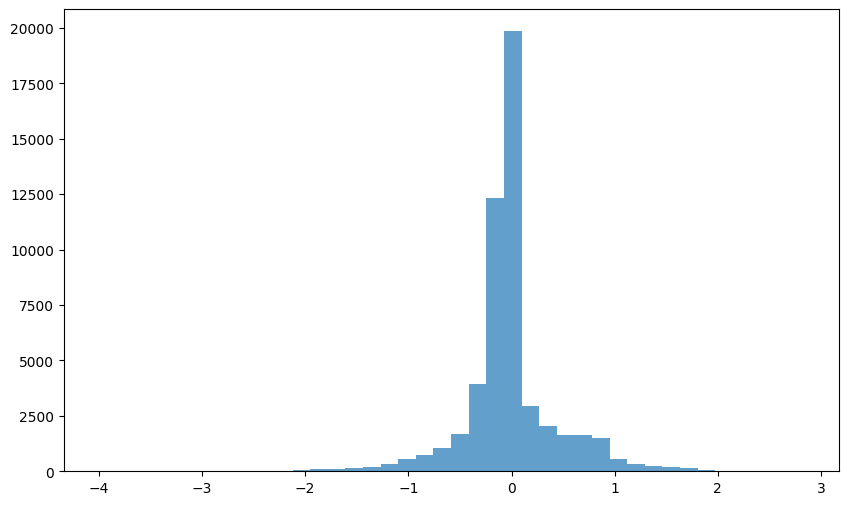

In [27]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

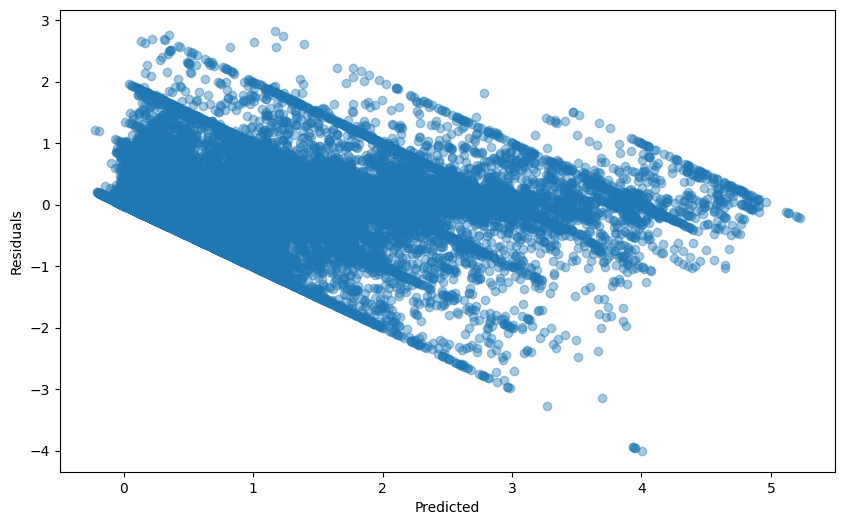

In [34]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

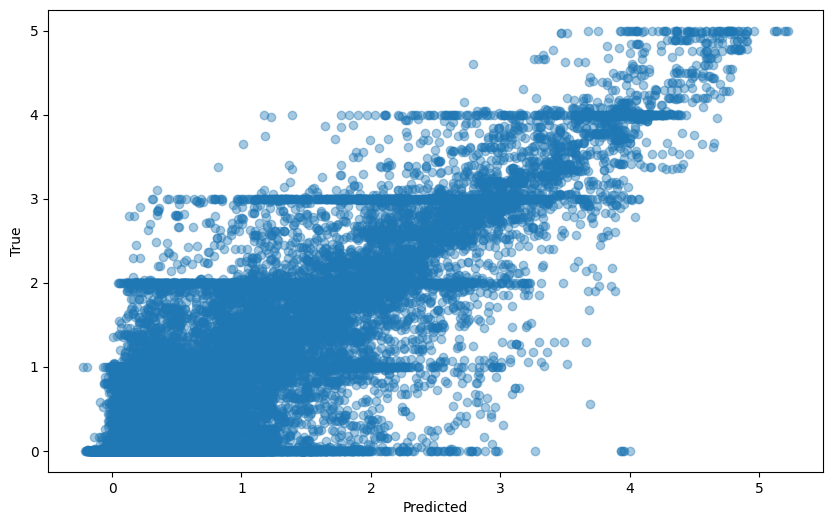

: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")